# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
import re 
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords as nltk_stopwords

import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en
import spacy

from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 2.3 MB/s eta 0:00:01��        | 10.3 MB 2.3 MB/s eta 0:00:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
display(data.head(20))

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [4]:
print(data.isna().sum())

Unnamed: 0    0
text          0
toxic         0
dtype: int64


In [5]:
data.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


In [6]:
data['text'] = data['text'].str.lower()

In [8]:
# Напишу функцию lemmatize(text). На вход она принимает текст из корпуса и возвращает лемматизированную строку.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

corpus = list(data['text'])

# Напишу функцию clear_text(text), которая оставит в тексте только символы и пробелы.
# На вход она принимает текст, а возвращает очищенный текст.

def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    doc = nlp(text)
    return  " ".join([token.lemma_ for token in doc])

print("Исходный текст:", corpus[0])
print("Очищенный и лемматизированный текст:", (clear_text(corpus[0])))

Исходный текст: explanation
why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27
Очищенный и лемматизированный текст: explanation why the edit make under my username hardcore metallica fan be revert   they weren t vandalisms   just closure on some gas after I vote at new york doll fac   and please don t remove the template from the talk page since I m retire now             


In [9]:
# В цикле применим функцию для очистки и лемматизации текстов "clear_text":
for i in tqdm(range(len(corpus))):
    corpus[i] = clear_text(corpus[i])

100%|██████████| 159292/159292 [20:26<00:00, 129.86it/s]


In [10]:
# Обьеденим датасет и корпус
data_corpus = pd.DataFrame(corpus)
data['lemm_text'] = data_corpus[0]
display(data.head())
data.info()

,Unnamed: 0,text,toxic,lemm_text
0,0,explanation\nwhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour I m se...
2,2,"hey man, i'm really not trying to edit war. it...",0,hey man I m really not try to edit war it ...
3,3,"""\nmore\ni can't make any real suggestions on ...",0,more I can t make any real suggestion on im...
4,4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you rememb...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
 3   lemm_text   159292 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


0    143106
1     16186
Name: toxic, dtype: int64


<AxesSubplot:xlabel='toxic', ylabel='count'>

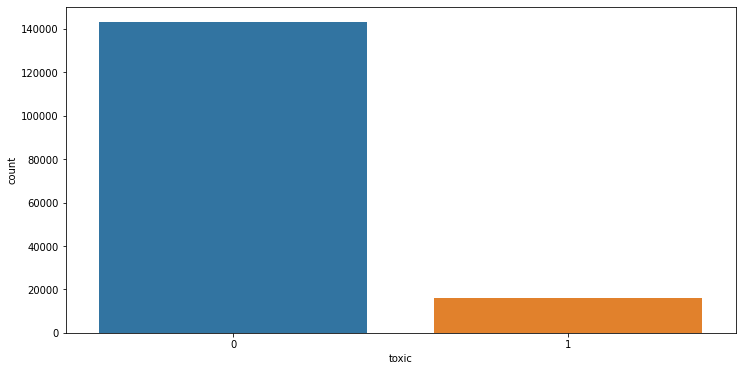

In [11]:
# Посмотрим количество токсичных слов
print(data['toxic'].value_counts())
zeroes = data['toxic'].value_counts()[0]
ones = data['toxic'].value_counts()[1]

plt.figure(figsize=(12, 6))
sns.countplot(x='toxic', data=data)

In [12]:
features = data['lemm_text']
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=34, stratify = target)

In [13]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

tf_features_train = count_tf_idf.fit_transform(features_train) 
tf_features_test = count_tf_idf.transform(features_test) 

print("Размер матрицы:", tf_features_train.shape)
print("Размер матрицы:", tf_features_test.shape)

Размер матрицы: (119469, 128479)
Размер матрицы: (39823, 128479)


In [21]:
features_train_cat = features_train[:2000]
features_test_cat = features_test[:800]
target_train_cat = target_train[:2000]
target_test_cat = target_test[:800]

In [22]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

features_train_cat = count_tf_idf.fit_transform(features_train_cat) 
features_test_cat = count_tf_idf.transform(features_test_cat)

In [23]:
print("Размер матрицы:", features_train_cat.shape)
print("Размер матрицы:", features_test_cat.shape)
print("Размер матрицы:", target_train_cat.shape)
print("Размер матрицы:", target_test_cat.shape)

Размер матрицы: (2000, 10985)
Размер матрицы: (800, 10985)
Размер матрицы: (2000,)
Размер матрицы: (800,)


## Обучение

In [54]:
model_lr_pl = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("clf", LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced', random_state=34)),
    ]
)


model_lr_pl.fit(features_train, target_train)
train_pred_pl = model_lr.predict(tf_features_train)


F1_lr_pl = cross_val_score(model_lr, tf_features_train, target_train, scoring='f1', cv=3).mean()
print(F1_lr_pl)

0.7523677683341236


In [42]:
model_lr = LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced', random_state=34)

model_lr.fit(tf_features_train, target_train)
train_pred = model_lr.predict(tf_features_train)


F1_lr = cross_val_score(model_lr, tf_features_train, target_train, scoring='f1', cv=3).mean()
print(F1_lr)

0.7523677683341236


In [19]:
model_forest=RandomForestClassifier(random_state=34, n_estimators=100)
model_forest.fit(tf_features_train, target_train)
prediction_forest=model_forest.predict(tf_features_train)

param_grid = { 'n_estimators': range(10, 50, 10),
                     'max_depth': range(1, 10, 2)}

clf = RandomForestClassifier()

grid_rf = GridSearchCV(clf, param_grid, scoring='f1', cv=3)
grid_rf.fit(tf_features_train, target_train)
F1_rf = grid_rf.best_score_
print(F1_rf)

0.0006587615283267455


In [24]:
model_cat = CatBoostClassifier(n_estimators=1000, random_state=34, verbose=100)
model_cat.fit(features_train_cat, target_train_cat, eval_set=(features_train_cat,target_train_cat))

params_cat = {
    'learning_rate': [0.1,0.4],
    'depth': [4, 10],
    }

grid_cat = GridSearchCV(estimator=model_cat,param_grid = params_cat, scoring='f1', cv=3)
grid_cat.fit(features_train_cat, target_train_cat)
F1_cat = grid_cat.best_score_
print(F1_cat)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.037607
0:	learn: 0.6611445	test: 0.6612065	best: 0.6612065 (0)	total: 109ms	remaining: 1m 48s
100:	learn: 0.2079364	test: 0.2080203	best: 0.2080203 (100)	total: 8.06s	remaining: 1m 11s
200:	learn: 0.1697979	test: 0.1698750	best: 0.1698750 (200)	total: 15.8s	remaining: 1m 2s
300:	learn: 0.1369880	test: 0.1370598	best: 0.1370598 (300)	total: 23.6s	remaining: 54.7s
400:	learn: 0.1135031	test: 0.1135692	best: 0.1135692 (400)	total: 31.5s	remaining: 47.1s
500:	learn: 0.0958543	test: 0.0959141	best: 0.0959141 (500)	total: 39.4s	remaining: 39.3s
600:	learn: 0.0813108	test: 0.0813691	best: 0.0813691 (600)	total: 47.4s	remaining: 31.5s
700:	learn: 0.0699738	test: 0.0700254	best: 0.0700254 (700)	total: 55.6s	remaining: 23.7s
800:	learn: 0.0604995	test: 0.0605475	best: 0.0605475 (800)	total: 1m 3s	remaining: 15.8s
900:	learn: 0.0528059	test: 0.0528482	best: 0.0528482 (900)	total: 1m 11s	remaining: 7.87s
999:	learn: 0.0464736	test: 0.0465103	best: 0.0465103 (999)	total: 1m 1

In [28]:
F1_cat = grid_cat.best_score_
print(F1_cat)

0.56635381758492


## Выводы

In [58]:
column=['F1 модели']

general_tabl = pd.DataFrame(index=['F1 модели'], columns=['LogisticRegression', 'LogisticRegression_pl' , 'RandomForestClassifier','CatBoostClassifier'])
general_tabl['LogisticRegression'] = F1_lr_pl
general_tabl['LogisticRegression_pl'] = F1_lr
general_tabl['RandomForestClassifier'] = F1_rf
general_tabl['CatBoostClassifier'] = F1_cat

general_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,F1 модели
LogisticRegression,0.752368
LogisticRegression_pl,0.752368
RandomForestClassifier,0.000659
CatBoostClassifier,0.566354


In [45]:
predict_lr_t=model_lr.predict(tf_features_test)
F1_lr_t = round(f1_score(target_test, predict_lr_t), 2)
print(F1_lr_t)

0.75


In [56]:
predict_lr_t_pl=model_lr_pl.predict(features_test)
F1_lr_t_pl = round(f1_score(target_test, predict_lr_t), 2)
print(F1_lr_t_pl)

0.75


In [27]:
predict_cat_t=grid_cat.predict(features_test_cat)
F1_cat_t =  round(f1_score(target_test_cat, predict_cat_t), 3)
print(F1_cat_t)

0.581


# Вывод:

Стоит отметить, что CatBoost классификатор выполняет расчеты в десятки раз дольше, нежели Логистическая регрессия, полученное при этом значение метрики f1 ниже, чем у Логистической регрессии, возможно при увеличении количества итераций мы получим результат будет стремиться к логистической регрессии и может быть лучше, но и количество времени на обучение мы потратим колосальное.
В связи с этим модели Логистическая регрессия и CatBoost классификатор подходят для решения поставленной задачи. Однако, для экономии времени и вычислителной мощности Логистическая регрессия является оптимальным решением для данной задачи.    